In [1]:
import time
start = time.perf_counter()

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
import time
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.mixture import GaussianMixture
from sklearn.random_projection import GaussianRandomProjection
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedShuffleSplit, learning_curve, validation_curve, GridSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, homogeneity_score, davies_bouldin_score, mean_squared_error, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, roc_curve, roc_auc_score, auc, precision_score, f1_score, classification_report, recall_score, average_precision_score, confusion_matrix, ConfusionMatrixDisplay, pairwise_distances, normalized_mutual_info_score
from sklearn.cluster import KMeans

In [3]:
N = 5
random_seeds = np.random.randint(0, 903967645, size=N)

In [4]:
default_payment_dataset = pd.read_csv('../data/default_of_credit_card_clients.csv', header=1)
print(default_payment_dataset.info())
default_payment_dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
# Check shape of dataset and for null data
print(default_payment_dataset.shape)
default_payment_dataset.isna().any().any()
print(default_payment_dataset.columns)

(30000, 25)
Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')


In [6]:
default_payment_dataset = default_payment_dataset.sample(frac=0.1, random_state=42)

# Separate features and target
train_X = default_payment_dataset.drop(columns=['ID', 'default payment next month', 'BILL_AMT4', 'BILL_AMT3', 'BILL_AMT6', 'BILL_AMT1', 'BILL_AMT2'])
train_y = default_payment_dataset['default payment next month']

# Normalize the feature data
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(train_X)

# Convert back to DataFrame
train_X = pd.DataFrame(X_scaled, columns=train_X.columns)
print(train_X.shape)

(300, 18)


In [7]:
dims = list(range(2, 24, 1))

In [8]:
def run_rp(train_X, components, seed):
    grp = GaussianRandomProjection(n_components=components, random_state=seed)
    grp_result = grp.fit_transform(train_X.values)
    return grp_result

# Run RP multiple times with different seeds
rp_results = []
for seed in random_seeds:
    rp_result = run_rp(train_X, components=5, seed=seed)
    rp_results.append(rp_result)

In [9]:
def calculate_distance_preservation(original_data, projected_data):
    original_distances = pairwise_distances(original_data)
    projected_distances = pairwise_distances(projected_data)
    preservation_ratio = np.mean(np.abs(original_distances - projected_distances) / (original_distances + 1e-8))
    return preservation_ratio

distance_preservation_ratios = []
for rp_result in rp_results:
    ratio = calculate_distance_preservation(train_X.values, rp_result)
    distance_preservation_ratios.append(ratio)

# Calculate mean and standard deviation of preservation ratios
mean_ratio = np.mean(distance_preservation_ratios)
std_ratio = np.std(distance_preservation_ratios)

print(f"Mean distance preservation ratio: {mean_ratio}")
print(f"Standard deviation of distance preservation ratio: {std_ratio}")

Mean distance preservation ratio: 0.2504929339575628
Standard deviation of distance preservation ratio: 0.03462550534112751


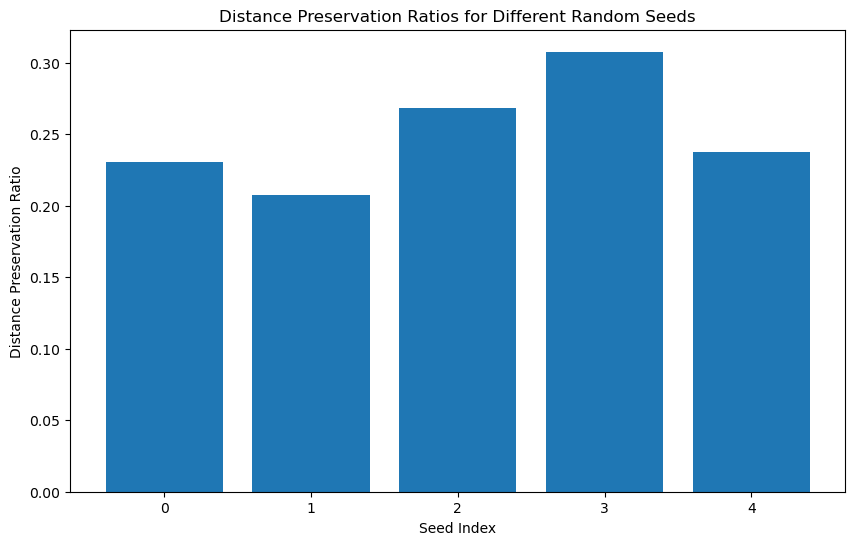

In [10]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(distance_preservation_ratios)), distance_preservation_ratios)
plt.title('Distance Preservation Ratios for Different Random Seeds')
plt.xlabel('Seed Index')
plt.ylabel('Distance Preservation Ratio')
plt.savefig('../images/rp_distance_preservation_ratios.png')
plt.show()

In [8]:
%%time
components = 5
grp = GaussianRandomProjection(n_components=components, random_state=1000)
grp_result = grp.fit_transform(train_X.values)
for i in range(components):
    field_name = "grp-"+str(i)
    train_X[field_name] = grp_result[:,i]
    default_payment_dataset[field_name] = grp_result[:,i]
train_X_grp = grp_result

CPU times: user 53.1 ms, sys: 71.3 ms, total: 124 ms
Wall time: 20.2 ms


2 :  0.0664363980869063
3 :  0.06496882728298334
4 :  0.06367076869332608
5 :  0.05322987396337421
6 :  0.0528330092028614
7 :  0.04633810007420557
8 :  0.044190162228174824
9 :  0.04232908749996849
10 :  0.037001522945482604
11 :  0.035219637468014466
12 :  0.032454836930840614
13 :  0.03160134387139081
14 :  0.02869068333842148
15 :  0.026519567004817772
16 :  0.025714577510689063
17 :  0.024868865953383997
18 :  0.021317095494575767
19 :  0.019092716890592554
20 :  0.01705806407691441
21 :  0.015006705687623972
22 :  0.005386078759910996
23 :  1.1174892783272576e-29


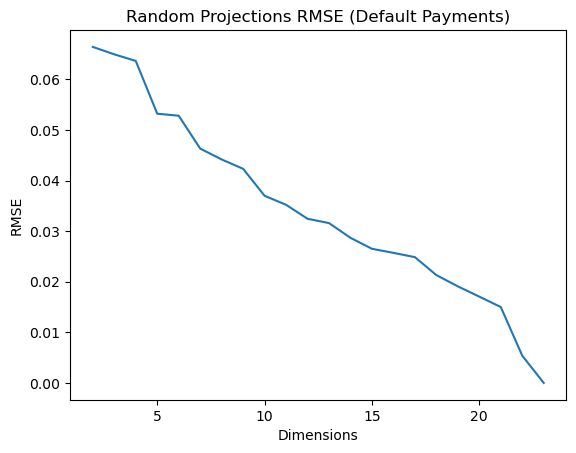

CPU times: user 859 ms, sys: 491 ms, total: 1.35 s
Wall time: 149 ms


In [9]:
%%time

rc_errors = {}

for dim in dims:
    grp = GaussianRandomProjection(n_components=dim, random_state=42)
    x_prime = grp.fit_transform(train_X.values)
    
    A = np.linalg.pinv(grp.components_.T)
    reconstructed = np.dot(x_prime, A)
    rc_err = mean_squared_error(train_X.values, reconstructed)    
    rc_errors[dim] = rc_err
    print(dim, ": ", rc_err)
    
plt.figure()
plt.plot(list(rc_errors.keys()), list(rc_errors.values()))
plt.xlabel("Dimensions")
plt.ylabel("RMSE")
plt.title('Random Projections RMSE (Default Payments)')
plt.savefig('../images/default-payments-rp-rmse.png')
plt.show()

In [11]:
def pairwise_distance_preservation(train_X, components, iterations=10, random_state=None, epsilon=1e-10):
    distance_preservation_ratios = []
    
    original_distances = pairwise_distances(train_X)
    
    for i in range(iterations):
        if random_state is not None:
            current_random_state = random_state + i  # Change random state for each iteration
        else:
            current_random_state = None
        
        grp = GaussianRandomProjection(n_components=components, random_state=current_random_state)
        grp_result = grp.fit_transform(train_X)
        
        projected_distances = pairwise_distances(grp_result)
        
        # Calculate the ratio of preserved distances
        preservation_ratio = np.mean(np.abs(original_distances - projected_distances) / (original_distances + epsilon))
        distance_preservation_ratios.append(preservation_ratio)
    
    return distance_preservation_ratios

# Assuming train_X is already defined and preprocessed
components = 5
iterations = 10
random_state = 42

# Calculate distance preservation ratios
distance_preservation_ratios = pairwise_distance_preservation(train_X.values, components, iterations, random_state)

# Print the results
print(f"Distance preservation ratios over {iterations} iterations: {distance_preservation_ratios}")
print(f"Mean distance preservation ratio: {np.mean(distance_preservation_ratios)}")
print(f"Standard deviation of distance preservation ratio: {np.std(distance_preservation_ratios)}")

# Plot the distance preservation ratios
plt.figure(figsize=(10, 6))

Distance preservation ratios over 10 iterations: [0.2646818256097652, 0.2509866807083601, 0.22357514052554367, 0.2699523183061797, 0.2329986359868324, 0.20550051207252087, 0.2258240813543601, 0.2361618170958339, 0.42461711135586966, 0.21717869571243176]
Mean distance preservation ratio: 0.25514768187276976
Standard deviation of distance preservation ratio: 0.05971725563472457


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

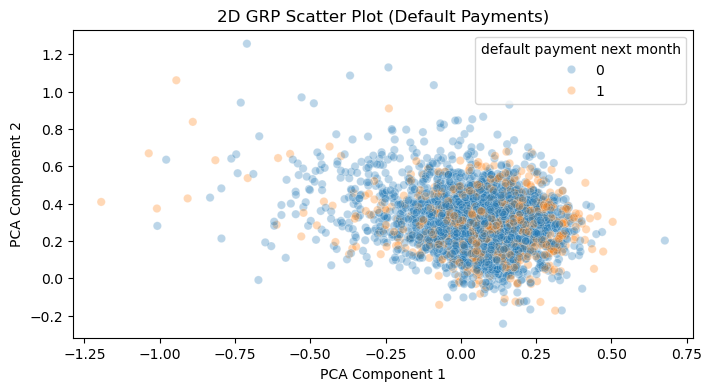

In [12]:
# Plotting the first two PCA components
plt.figure(figsize=(8, 4))
sns.scatterplot(
    x='grp-0', y='grp-1',
    hue='default payment next month',
    palette=sns.color_palette('tab10', 2),
    data=default_payment_dataset,
    legend='full',
    alpha=0.3
)
plt.xlabel('RP Component 1')
plt.ylabel('RP Component 2')
plt.title('2D RP Scatter Plot (Default Payments)')
plt.savefig('../images/default-payments-nn-rp-2d.png')
plt.show()

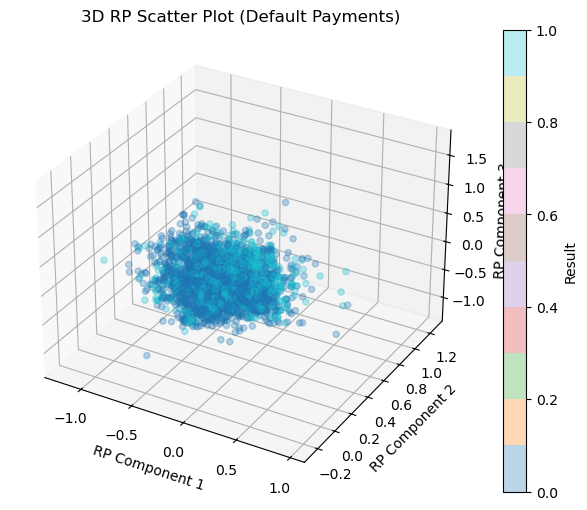

In [10]:
# 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    xs=default_payment_dataset["grp-0"], 
    ys=default_payment_dataset["grp-1"], 
    zs=default_payment_dataset["grp-2"], 
    c=default_payment_dataset["default payment next month"], 
    cmap='tab10',
    alpha=0.3
)
ax.set_xlabel('RP Component 1')
ax.set_ylabel('RP Component 2')
ax.set_zlabel('RP Component 3')
plt.colorbar(scatter, ax=ax, label='Result')
plt.title('3D RP Scatter Plot (Default Payments)')
fig.savefig('../images/default-payments-nn-rp-3d.png')
plt.show()

# Clustering

For n_clusters=2, The sse is 1816.717835484924
For n_clusters=3, The sse is 1558.962696420701
For n_clusters=4, The sse is 1407.0843792423386
For n_clusters=5, The sse is 1256.059407939806
For n_clusters=6, The sse is 1179.096131204247
For n_clusters=7, The sse is 1123.3206633073996
For n_clusters=8, The sse is 1093.823037878577
For n_clusters=9, The sse is 999.320298143808
For n_clusters=10, The sse is 942.7587045841361
For n_clusters=11, The sse is 912.0192703961093
For n_clusters=12, The sse is 901.801819624257
For n_clusters=13, The sse is 851.7401094374513
For n_clusters=14, The sse is 835.2740516398824
For n_clusters=15, The sse is 805.5750410018708
For n_clusters=16, The sse is 782.1882983862478
For n_clusters=17, The sse is 752.9496595432313
For n_clusters=18, The sse is 739.3473556781921
For n_clusters=19, The sse is 734.8059738059221
For n_clusters=20, The sse is 724.090721040355
For n_clusters=21, The sse is 702.5103451745947
For n_clusters=22, The sse is 689.6236826207032
F

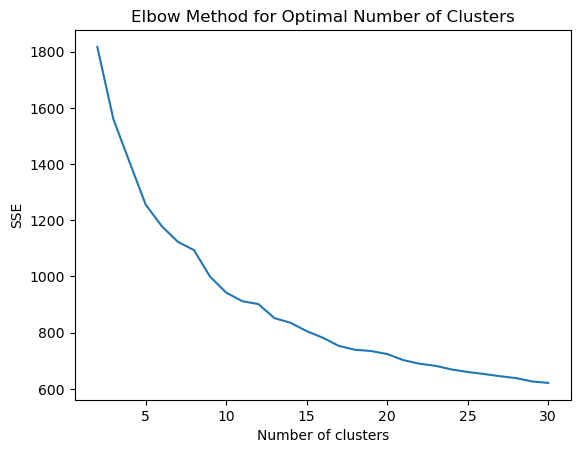

In [15]:
clusters = list(range(2, 31, 1))
sse = {}

for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster, max_iter=1000, random_state=42).fit(train_X)
    error = kmeans.inertia_
    sse[cluster] = error
    print(f"For n_clusters={cluster}, The sse is {error}")


plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal Number of Clusters")
plt.savefig('../images/default-payments-elbow-sse.png')
plt.show()

In [ ]:
%%time
silhouette_coeffs_KM = {}
homogeneity_scores_KM = {}

for cluster in range(2, 31, 1):
    kmeans = KMeans(n_clusters=cluster, n_init=50, max_iter=1000, random_state=42).fit(train_X_grp)
    label = kmeans.labels_
    sil_coeff = silhouette_score(train_X_grp, label, metric='euclidean')
    homog_score = homogeneity_score(train_y, label)
    silhouette_coeffs_KM[cluster] = sil_coeff
    homogeneity_scores_KM[cluster] = homog_score
    print(f"For n_clusters={cluster}, The Silhouette Coefficient is {sil_coeff}")
    print(f"For n_clusters={cluster}, The homogeneity_score is {homog_score}")
    
# Plotting Silhouette Coefficients
plt.figure(figsize=(8, 4))
plt.plot(list(silhouette_coeffs_KM.keys()), list(silhouette_coeffs_KM.values()), marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.title("KMeans - Silhouette Coefficient for Various Numbers of Clusters - Randomized Projections (Default Payments)")
plt.grid(True)
fig.savefig('../images/default-payments-rp-kmeans-silhouette.png')
plt.show()

In [ ]:
# Plotting Silhouette Coefficient and Homogeneity Score
plt.figure(figsize=(8, 4))
plt.plot(list(silhouette_coeffs_KM.keys()), list(silhouette_coeffs_KM.values()), 'b', label='Silhouette Coefficient', marker='o')
plt.plot(list(homogeneity_scores_KM.keys()), list(homogeneity_scores_KM.values()), 'r', label='Homogeneity Score', marker='x')
plt.legend(loc='best')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('KMeans - Silhouette Coefficient and Homogeneity Score for Various Numbers of Clusters - Randomized Projections (Default Payments)')
plt.savefig('../images/default-payments-rp-kmeans-silhouette-and-homogeneity.png')
plt.grid(True)
plt.show()

In [ ]:
%%time
clusters = list(range(2, 31))
log_likelihood_em = []
silhouette_scores_em = []
davies_bouldin_scores_em = []
homogeneity_scores_em = []

for cluster in clusters:
    gmm = GaussianMixture(n_components=cluster, n_init=10, max_iter=100, random_state=42).fit(train_X_grp)
    labels = gmm.predict(train_X_grp)
    log_likelihood = gmm.score(train_X_grp)
    silhouette = silhouette_score(train_X_grp, labels)
    davies_bouldin = davies_bouldin_score(train_X, labels)
    homogeneity = homogeneity_score(train_y, labels)
    
    log_likelihood_em.append(log_likelihood)
    silhouette_scores_em.append(silhouette)
    davies_bouldin_scores_em.append(davies_bouldin)    
    homogeneity_scores_em.append(homogeneity)

    print(f"For n_clusters={cluster}, The log likelihood is {log_likelihood}")
    print(f"For n_clusters={cluster}, The Silhouette Coefficient is {silhouette}")
    print(f"For n_clusters={cluster}, The Davies Bouldin Score is {davies_bouldin}")
    print(f"For n_clusters={cluster}, The Homogeneity Score is {homogeneity}")

# Plotting Log Likelihood (Elbow Method)
plt.figure(figsize=(8, 4))
plt.plot(clusters, log_likelihood_em, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Log Likelihood")
plt.title("RP Elbow Method for Optimal Number of Clusters (EM)")
plt.grid(True)
plt.savefig('../images/default-payments-rp-em-log-likelihood-elbow-method.png')
plt.show()

# Plotting Silhouette Score
plt.figure(figsize=(8, 4))
plt.plot(clusters, silhouette_scores_em, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("RP Silhouette Score for Optimal Number of Clusters (EM)")
plt.grid(True)
plt.savefig('../images/default-payments-rp-em-sihouette-coefficients.png')
plt.show()

# Plotting Davies-Bouldin Index
plt.figure(figsize=(8, 4))
plt.plot(clusters, davies_bouldin_scores_em, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Index")
plt.title("RP Davies-Bouldin Index for Optimal Number of Clusters (EM)")
plt.grid(True)
plt.savefig('../images/default-payments-rp-em-davies-bouldin-index.png')
plt.show()

# Plotting Silhouette Coefficient and Homogeneity Score
plt.figure(figsize=(10, 6))
plt.plot(list(silhouette_coeffs_em.keys()), list(silhouette_coeffs_em.values()), 'b', label='Silhouette Coefficient', marker='o')
plt.plot(list(homogeneity_scores_em.keys()), list(homogeneity_scores_em.values()), 'r', label='Homogeneity Score', marker='x')
plt.legend(loc='best')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Expectation Maximization - Silhouette Coefficient and Homogeneity Score for Various Numbers of Clusters - RP')
plt.grid(True)
plt.savefig('../images/default-payments-rp-em-sihouette-and-homogeneity.png')
plt.show()

In [ ]:
# Plotting Silhouette Coefficient and Homogeneity Score
plt.figure(figsize=(8, 4))
plt.plot(list(silhouette_coeffs_EM.keys()), list(silhouette_coeffs_EM.values()), 'b', label='Silhouette Coefficient', marker='o')
plt.plot(list(homogeneity_scores_EM.keys()), list(homogeneity_scores_EM.values()), 'r', label='Homogeneity Score', marker='x')
plt.legend(loc='best')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Expectation Maximization - Random Projections Silhouette Coefficient and Homogeneity Score for Various Numbers of Clusters (Default Payments)')
plt.savefig('../images/default-payments-rp-em-silhouette-homogeneity.png')
plt.grid(True)
plt.show()

In [22]:
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(train_X_grp)
kmeans_labels = kmeans.labels_

In [23]:
train_X['KMeans_Cluster'] = kmeans_labels

In [24]:
gmm = GaussianMixture(n_components=5, random_state=42)
gmm.fit(train_X_grp)
gmm_labels = gmm.predict(train_X_grp)

In [25]:
train_X['GMM_Cluster'] = gmm_labels
print(train_X.head())

   LIMIT_BAL  SEX  EDUCATION  MARRIAGE       AGE  PAY_0     PAY_2  PAY_3  \
0   0.025316  0.0   0.333333  0.666667  0.081633    0.2  0.222222    0.2   
1   0.177215  1.0   0.166667  0.666667  0.102041    0.2  0.222222    0.2   
2   0.075949  1.0   0.500000  0.333333  0.224490    0.2  0.222222    0.2   
3   0.151899  0.0   0.500000  0.666667  0.571429    0.2  0.222222    0.2   
4   0.050633  1.0   0.333333  0.666667  0.306122    0.2  0.222222    0.2   

      PAY_4     PAY_5  ...  PAY_AMT4  PAY_AMT5  PAY_AMT6     grp-0     grp-1  \
0  0.222222  0.222222  ...  0.006459  0.004942  0.003783  0.181858  0.157360   
1  0.222222  0.222222  ...  0.011398  0.008794  0.005049  0.037383  0.284098   
2  0.222222  0.222222  ...  0.010498  0.008237  0.004831  0.068628  0.491289   
3  0.222222  0.222222  ...  0.000116  0.023100  0.008338  0.011895  0.255403   
4  0.222222  0.222222  ...  0.007751  0.000000  0.001892  0.252736  0.287382   

      grp-2     grp-3     grp-4  KMeans_Cluster  GMM_Cluster  

In [26]:
features_to_plot = ['grp-0', 'grp-1']
# Get unique clusters for KMeans and GMM
unique_clusters_kmeans = np.unique(train_X['KMeans_Cluster'])
unique_clusters_gmm = np.unique(train_X['GMM_Cluster'])

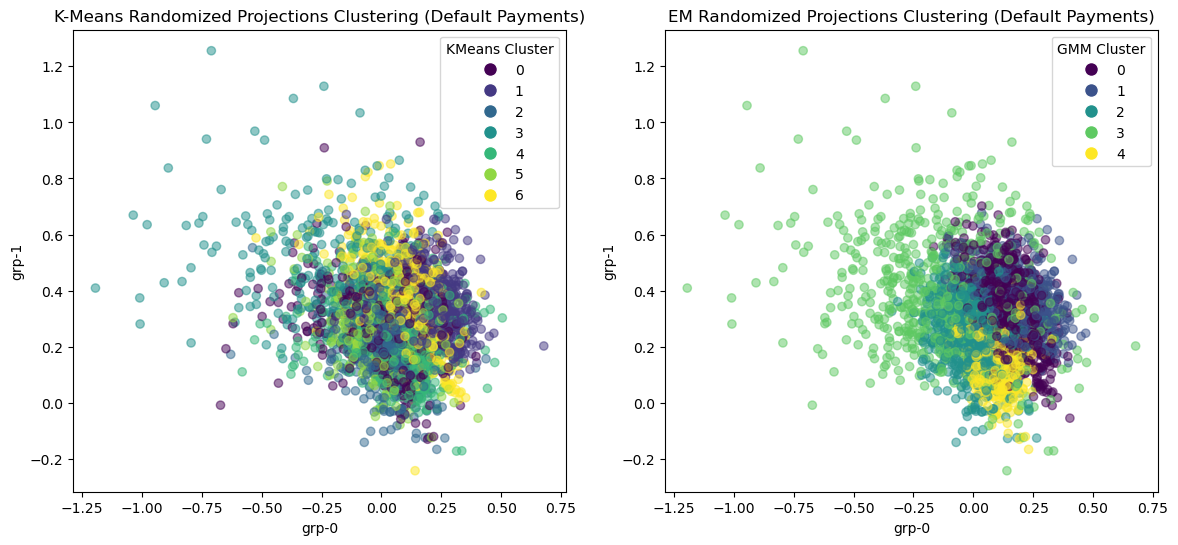

In [27]:
# Create a figure with subplots
plt.figure(figsize=(14, 6))

# Plot K-Means clustering results
plt.subplot(1, 2, 1)
scatter_kmeans = plt.scatter(train_X[features_to_plot[0]], train_X[features_to_plot[1]], c=train_X['KMeans_Cluster'], cmap='viridis', alpha=0.5)
plt.title('K-Means Randomized Projections Clustering (Default Payments)')
plt.xlabel(features_to_plot[0])
plt.ylabel(features_to_plot[1])
handles_kmeans = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_kmeans.cmap(scatter_kmeans.norm(cluster)), markersize=10) for cluster in unique_clusters_kmeans]
plt.legend(handles_kmeans, unique_clusters_kmeans, title='KMeans Cluster', loc='best')

# Plot GMM clustering results
plt.subplot(1, 2, 2)
scatter_gmm = plt.scatter(train_X[features_to_plot[0]], train_X[features_to_plot[1]], c=train_X['GMM_Cluster'], cmap='viridis', alpha=0.5)
plt.title('EM Randomized Projections Clustering (Default Payments)')
plt.xlabel(features_to_plot[0])
plt.ylabel(features_to_plot[1])
handles_gmm = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_gmm.cmap(scatter_gmm.norm(cluster)), markersize=10) for cluster in unique_clusters_gmm]
plt.legend(handles_gmm, unique_clusters_gmm, title='GMM Cluster', loc='best')

# Save the plot
plt.savefig('../images/default-payments-rp-clustering-comparison.png')

# Show the plot
plt.show()

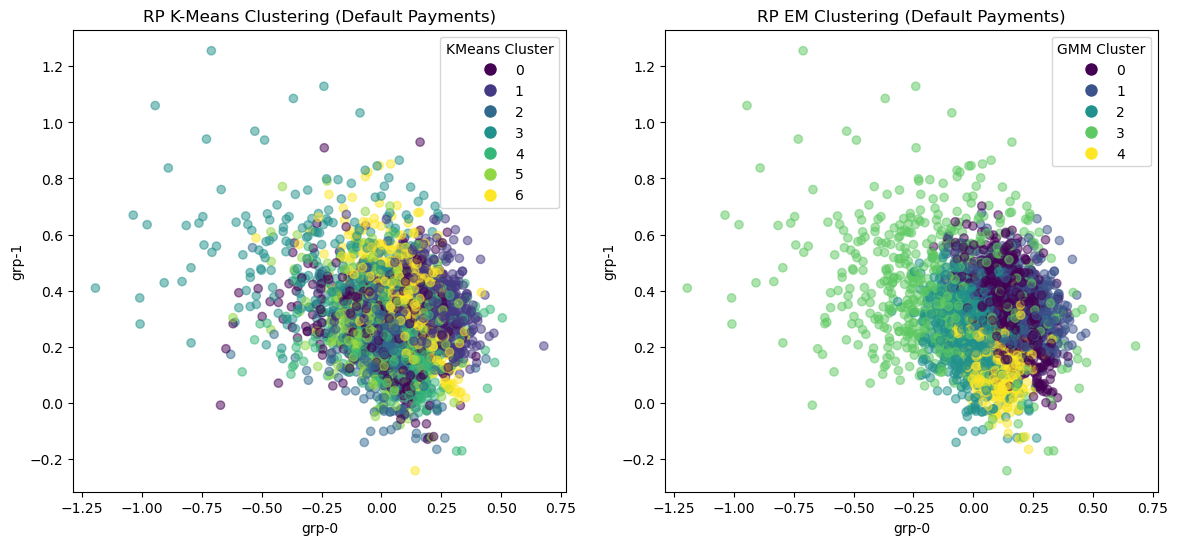

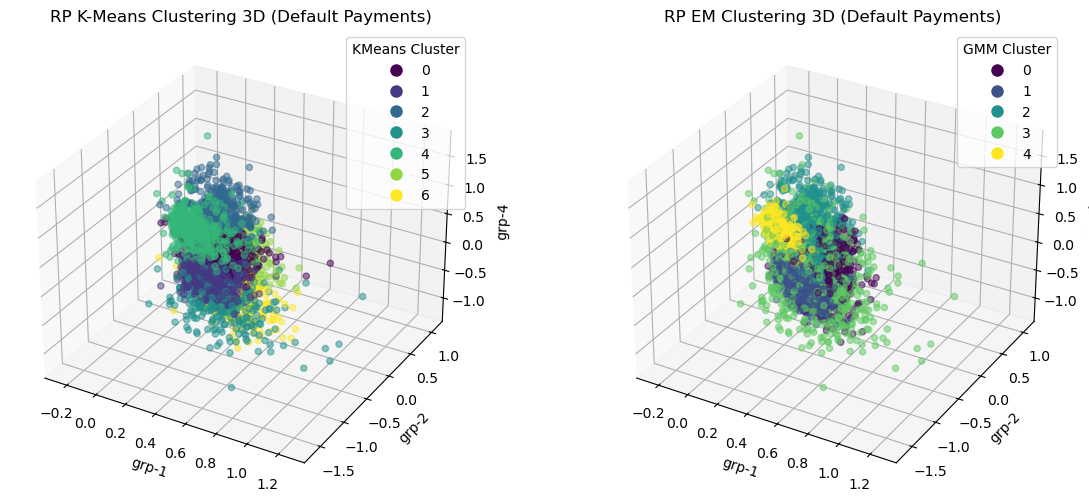

In [50]:
# Define the features you want to plot in 3D
features_to_plot_3d = ['grp-1', 'grp-2', 'grp-4']

# Create a figure for 2D K-Means and EM clustering results
fig_2d = plt.figure(figsize=(14, 6))

# 2D Plot for K-Means clustering results
ax1 = fig_2d.add_subplot(121)
scatter_kmeans = ax1.scatter(train_X[features_to_plot[0]], train_X[features_to_plot[1]], c=train_X['KMeans_Cluster'], cmap='viridis', alpha=0.5)
ax1.set_title('RP K-Means Clustering (Default Payments)')
ax1.set_xlabel(features_to_plot[0])
ax1.set_ylabel(features_to_plot[1])
handles_kmeans = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_kmeans.cmap(scatter_kmeans.norm(cluster)), markersize=10) for cluster in unique_clusters_kmeans]
ax1.legend(handles_kmeans, unique_clusters_kmeans, title='KMeans Cluster', loc='best')

# 2D Plot for EM clustering results
ax2 = fig_2d.add_subplot(122)
scatter_gmm = ax2.scatter(train_X[features_to_plot[0]], train_X[features_to_plot[1]], c=train_X['GMM_Cluster'], cmap='viridis', alpha=0.5)
ax2.set_title('RP EM Clustering (Default Payments)')
ax2.set_xlabel(features_to_plot[0])
ax2.set_ylabel(features_to_plot[1])
handles_gmm = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_gmm.cmap(scatter_gmm.norm(cluster)), markersize=10) for cluster in unique_clusters_gmm]
ax2.legend(handles_gmm, unique_clusters_gmm, title='GMM Cluster', loc='best')

fig_2d.savefig('../images/default-payments-comparison-rp-2D.png')
plt.show()

# Create a figure for 3D K-Means and EM clustering results
fig_3d = plt.figure(figsize=(14, 6))

# 3D Plot for K-Means clustering results
ax1 = fig_3d.add_subplot(121, projection='3d')
scatter_kmeans_3d = ax1.scatter(train_X[features_to_plot_3d[0]], train_X[features_to_plot_3d[1]], train_X[features_to_plot_3d[2]], c=train_X['KMeans_Cluster'], cmap='viridis', alpha=0.5)
ax1.set_title('RP K-Means Clustering 3D (Default Payments)')
ax1.set_xlabel(features_to_plot_3d[0])
ax1.set_ylabel(features_to_plot_3d[1])
ax1.set_zlabel(features_to_plot_3d[2], rotation=90)
ax1.legend(handles_kmeans, unique_clusters_kmeans, title='KMeans Cluster', loc='best')

# 3D Plot for EM clustering results
ax2 = fig_3d.add_subplot(122, projection='3d')
scatter_gmm_3d = ax2.scatter(train_X[features_to_plot_3d[0]], train_X[features_to_plot_3d[1]], train_X[features_to_plot_3d[2]], c=train_X['GMM_Cluster'], cmap='viridis', alpha=0.5)
ax2.set_title('RP EM Clustering 3D (Default Payments)')
ax2.set_xlabel(features_to_plot_3d[0])
ax2.set_ylabel(features_to_plot_3d[1])
ax2.set_zlabel(features_to_plot_3d[2])
ax2.legend(handles_gmm, unique_clusters_gmm, title='GMM Cluster', loc='best')

fig_3d.savefig('../images/default-payments-comparison-rp-3D.png')
plt.show()

In [47]:
# Calculate ARI
ari_score = adjusted_rand_score(train_X['KMeans_Cluster'], train_X['GMM_Cluster'])
print(f'Adjusted Rand Index (ARI) between KMeans and GMM clusters RP: {ari_score}')

# Calculate NMI
nmi_score = normalized_mutual_info_score(train_X['KMeans_Cluster'], train_X['GMM_Cluster'])
print(f'Normalized Mutual Information (NMI) between KMeans and GMM clusters RP: {nmi_score}')

Adjusted Rand Index (ARI) between KMeans and GMM clusters RP: 0.24202550037845022
Normalized Mutual Information (NMI) between KMeans and GMM clusters RP: 0.32745972884587327


# Neural Network

In [26]:
%%time

# Ensure train_X_grp and train_y are pandas DataFrames/Series
train_X_grp = pd.DataFrame(train_X_grp)
train_y = pd.Series(train_y)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(train_X_grp, train_y):
    strat_train_set = train_X_grp.iloc[train_index]
    strat_test_set = train_X_grp.iloc[test_index]
    strat_train_labels = train_y.iloc[train_index]
    strat_test_labels = train_y.iloc[test_index]

train_X_grp = strat_train_set
test_X_grp = strat_test_set
train_y = strat_train_labels
test_y = strat_test_labels

CPU times: user 3.5 ms, sys: 2.57 ms, total: 6.07 ms
Wall time: 3.91 ms


In [27]:
neural_net = MLPClassifier(random_state=42)
neural_net.fit(train_X_grp, train_y)

MLPClassifier(random_state=42)

In [28]:
%%time
# Evaluate on training data
train_predictions = neural_net.predict(train_X_grp)
train_accuracy = accuracy_score(train_y, train_predictions)
train_roc_auc = roc_auc_score(train_y, train_predictions)
train_precision = precision_score(train_y, train_predictions)
train_recall = recall_score(train_y, train_predictions)
train_f1 = f1_score(train_y, train_predictions)

print("Training Accuracy:", train_accuracy)
print("Training ROC AUC Score:", train_roc_auc)
print("Training Precision:", train_precision)
print("Training Recall:", train_recall)
print("Training F1 Score:", train_f1)
train_report = classification_report(train_y, train_predictions)
print(train_report)

# Write to a text file
with open('../results/default-payments-nn-rp-training_metrics_report.txt', 'w') as file:
    file.write("Training Accuracy: " + str(train_accuracy) + "\n")
    file.write("Training ROC AUC Score: " + str(train_roc_auc) + "\n")
    file.write("Training Precision: " + str(train_precision) + "\n")
    file.write("Training Recall: " + str(train_recall) + "\n")
    file.write("Training F1 Score: " + str(train_f1) + "\n")
    file.write("\nClassification Report:\n")
    file.write(train_report + "\n")

Training Accuracy: 0.795
Training ROC AUC Score: 0.5700248513024899
Training Precision: 0.6223776223776224
Training Recall: 0.16888045540796964
Training F1 Score: 0.2656716417910448
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      1873
           1       0.62      0.17      0.27       527

    accuracy                           0.80      2400
   macro avg       0.71      0.57      0.57      2400
weighted avg       0.77      0.80      0.75      2400

CPU times: user 129 ms, sys: 238 ms, total: 367 ms
Wall time: 48.8 ms


In [29]:
%%time
# Evaluate testing data
test_predictions = neural_net.predict(test_X_grp)
test_accuracy = accuracy_score(test_y, test_predictions)
test_roc_auc = roc_auc_score(test_y, test_predictions)
test_precision = precision_score(test_y, test_predictions)
test_recall = recall_score(test_y, test_predictions)
test_f1 = f1_score(test_y, test_predictions)

print("Testing Accuracy:", test_accuracy)
print("Testing ROC AUC Score:", test_roc_auc)
print("Testing Precision:", test_precision)
print("Testing Recall:", test_recall)
print("Testing F1 Score:", test_f1)
test_report = classification_report(test_y, test_predictions)
print(test_report)

# Write to a text file
with open('../results/default-payments-nn-rp-testing_metrics_report.txt', 'w') as file:
    file.write("Testing Accuracy: " + str(test_accuracy) + "\n")
    file.write("Testing ROC AUC Score: " + str(test_roc_auc) + "\n")
    file.write("Testing Precision: " + str(test_precision) + "\n")
    file.write("Testing Recall: " + str(test_recall) + "\n")
    file.write("Testing F1 Score: " + str(test_f1) + "\n")
    file.write("\nClassification Report:\n")
    file.write(test_report + "\n")

Testing Accuracy: 0.79
Testing ROC AUC Score: 0.5608003108003108
Testing Precision: 0.5882352941176471
Testing Recall: 0.15151515151515152
Testing F1 Score: 0.24096385542168675
              precision    recall  f1-score   support

           0       0.80      0.97      0.88       468
           1       0.59      0.15      0.24       132

    accuracy                           0.79       600
   macro avg       0.70      0.56      0.56       600
weighted avg       0.76      0.79      0.74       600

CPU times: user 187 ms, sys: 68.3 ms, total: 255 ms
Wall time: 34 ms


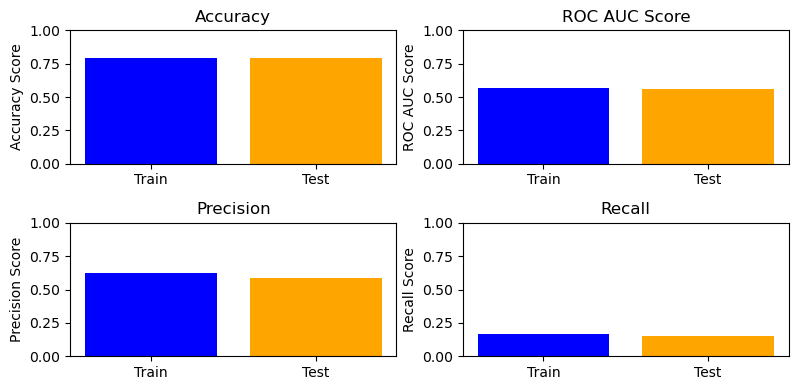

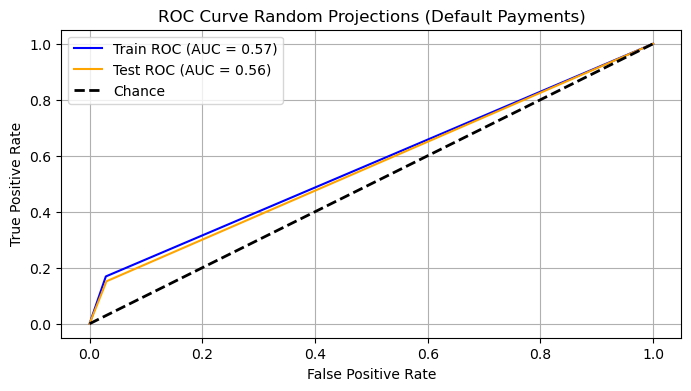

CPU times: user 773 ms, sys: 18.3 ms, total: 792 ms
Wall time: 286 ms


In [30]:
%%time
fig, ax = plt.subplots(2, 2, figsize=(8, 4))

# Accuracy
ax[0, 0].bar(['Train', 'Test'], [train_accuracy, test_accuracy], color=['blue', 'orange'])
ax[0, 0].set_title('Accuracy')
ax[0, 0].set_ylim([0, 1])
ax[0, 0].set_ylabel('Accuracy Score')

# ROC AUC Score
ax[0, 1].bar(['Train', 'Test'], [train_roc_auc, test_roc_auc], color=['blue', 'orange'])
ax[0, 1].set_title('ROC AUC Score')
ax[0, 1].set_ylim([0, 1])
ax[0, 1].set_ylabel('ROC AUC Score')

# Precision
ax[1, 0].bar(['Train', 'Test'], [train_precision, test_precision], color=['blue', 'orange'])
ax[1, 0].set_title('Precision')
ax[1, 0].set_ylim([0, 1])
ax[1, 0].set_ylabel('Precision Score')

# Recall
ax[1, 1].bar(['Train', 'Test'], [train_recall, test_recall], color=['blue', 'orange'])
ax[1, 1].set_title('Recall')
ax[1, 1].set_ylim([0, 1])
ax[1, 1].set_ylabel('Recall Score')

plt.tight_layout()
fig.savefig('../images/default-payments-nn-rp-metrics-comparison.png')
plt.show()

# Plotting  ROC Curves
train_fpr, train_tpr, _ = roc_curve(train_y, train_predictions)
test_fpr, test_tpr, _ = roc_curve(test_y, test_predictions)

plt.figure(figsize=(8, 4))
plt.plot(train_fpr, train_tpr, label=f'Train ROC (AUC = {auc(train_fpr, train_tpr):.2f})', color='blue')
plt.plot(test_fpr, test_tpr, label=f'Test ROC (AUC = {auc(test_fpr, test_tpr):.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.title('ROC Curve Random Projections (Default Payments)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('../images/default-payments-nn-rp-roc-curve')
plt.show()

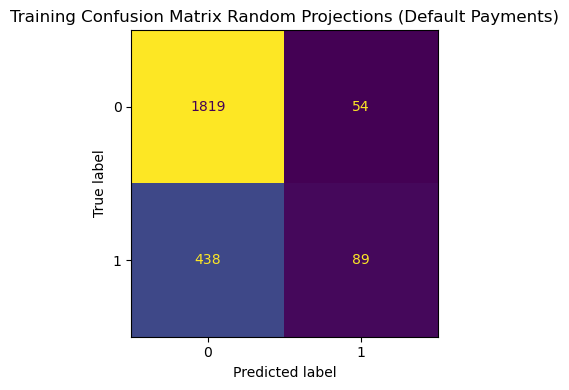

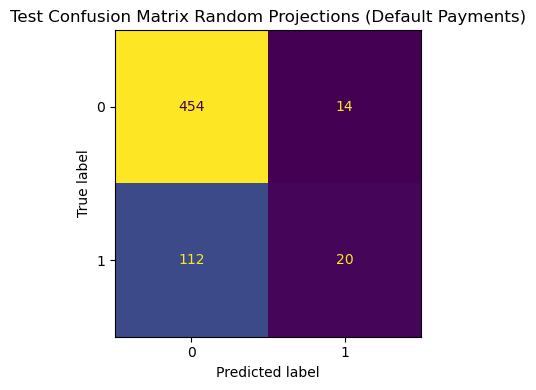

CPU times: user 378 ms, sys: 15.2 ms, total: 393 ms
Wall time: 141 ms


In [31]:
%%time
# Plot and save Training Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 4))
train_cm = confusion_matrix(train_y, train_predictions)
ConfusionMatrixDisplay(train_cm).plot(ax=ax, colorbar=False)
ax.set_title("Training Confusion Matrix Random Projections (Default Payments)")
plt.tight_layout()
plt.savefig('../images/default-payments-nn-rp-training-cm.png')
plt.show()

# Plot and save Test Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 4))
test_cm = confusion_matrix(test_y, test_predictions)
ConfusionMatrixDisplay(test_cm).plot(ax=ax, colorbar=False)
ax.set_title('Test Confusion Matrix Random Projections (Default Payments)')
plt.tight_layout()
plt.savefig('../images/default-payments-nn-rp-testing-cm.png')
plt.show()

Training progress:   0%|          | 0/10 [00:00<?, ?it/s]

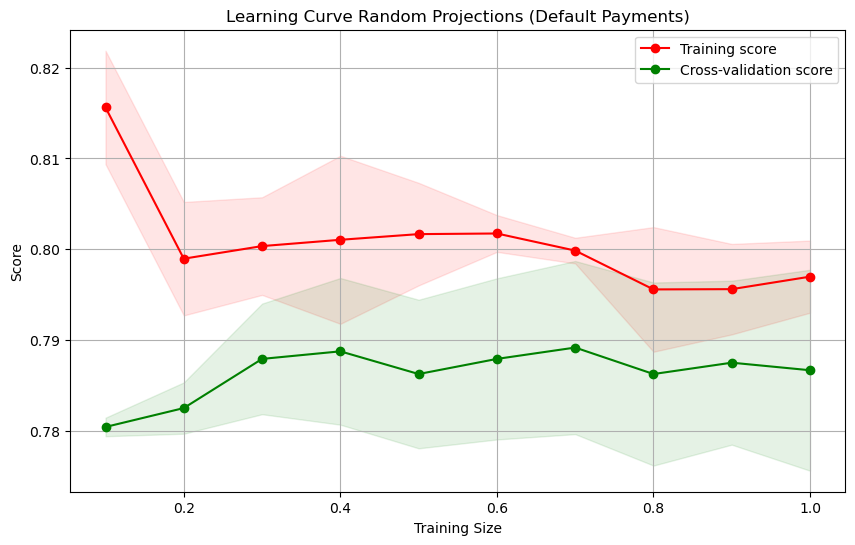

CPU times: user 2min 52s, sys: 6.42 s, total: 2min 58s
Wall time: 18.9 s


In [32]:
%%time
# Create a wrapper function for learning_curve to show progress
def learning_curve_with_progress(estimator, X, y, cv, scoring, train_sizes):
    all_train_scores = []
    all_test_scores = []
    for train_size in tqdm(train_sizes, desc='Training progress'):
        _, train_scores, test_scores = learning_curve(estimator, X, y, train_sizes=[train_size], cv=cv, scoring=scoring)
        all_train_scores.append(train_scores)
        all_test_scores.append(test_scores)
    return train_sizes, np.array(all_train_scores).squeeze(), np.array(all_test_scores).squeeze()

train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve_with_progress(neural_net, train_X_grp, train_y, cv=5, scoring='accuracy', train_sizes=train_sizes)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='g')

plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

plt.title('Learning Curve Random Projections (Default Payments)')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.savefig('../images/default-payments-nn-rp-learning-curve-training-size.png')
plt.show()

Validation progress:   0%|          | 0/3 [00:00<?, ?it/s]

/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimize

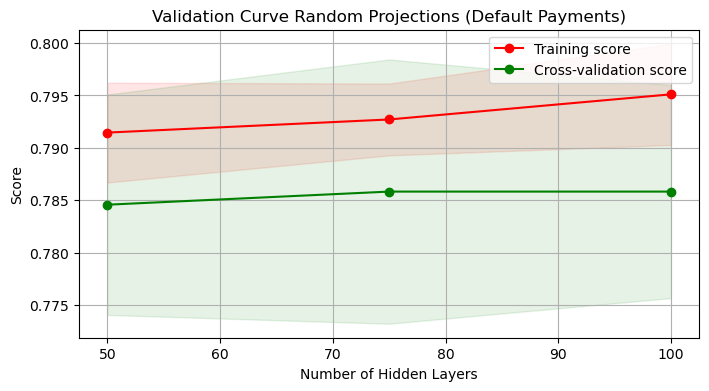

CPU times: user 695 ms, sys: 1.24 s, total: 1.94 s
Wall time: 2.78 s


In [33]:
%%time
param_range = [50, 75, 100]

# Function to calculate validation curve with progress bar
def validation_curve_with_progress(estimator, X, y, param_name, param_range, cv, scoring, n_jobs):
    train_scores = []
    test_scores = []
    for param in tqdm(param_range, desc='Validation progress'):
        train_score, test_score = validation_curve(estimator, X, y, param_name=param_name, param_range=[param], cv=cv, scoring=scoring, n_jobs=n_jobs)
        train_scores.append(train_score)
        test_scores.append(test_score)
    return np.array(train_scores).squeeze(), np.array(test_scores).squeeze()

train_scores, test_scores = validation_curve_with_progress(MLPClassifier(), train_X_grp, train_y, param_name="hidden_layer_sizes", param_range=param_range, cv=5, scoring='accuracy', n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 4))
plt.plot(param_range, train_scores_mean, 'o-', color='r', label="Training score")
plt.plot(param_range, test_scores_mean, 'o-', color='g', label="Cross-validation score")

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='g')

plt.title('Validation Curve Random Projections (Default Payments)')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.savefig('../images/default-payments-nn-rp-validation-curve-hidden-layers.png')
plt.show()

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimize

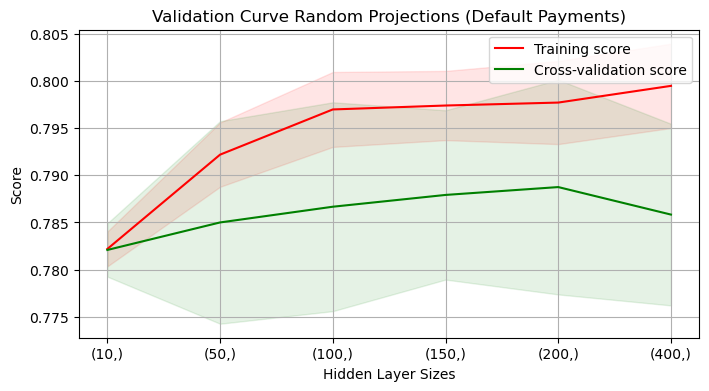

CPU times: user 314 ms, sys: 26.6 ms, total: 340 ms
Wall time: 4.36 s


In [34]:
%%time
# Define the range for the hyperparameter hidden_layer_sizes
param_range = [(10,), (50,), (100,), (150,), (200,), (400,)]
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Function to calculate validation curve with progress bar
def validation_curve_with_progress(estimator, X, y, param_name, param_range, cv, scoring, n_jobs):
    train_scores = []
    test_scores = []
    for param in tqdm(param_range, desc='Validation progress'):
        train_score, test_score = validation_curve(estimator, X, y, param_name=param_name, param_range=[param], cv=cv, scoring=scoring, n_jobs=n_jobs)
        train_scores.append(train_score)
        test_scores.append(test_score)
    return np.array(train_scores).squeeze(), np.array(test_scores).squeeze()

# Calculate validation curve data
train_scores, test_scores = validation_curve_with_progress(
    MLPClassifier(random_state=42), train_X_grp, train_y, param_name="hidden_layer_sizes", param_range=param_range, cv=5, scoring="accuracy", n_jobs=-1
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot validation curve
plt.figure(figsize=(8, 4))
plt.plot([str(x) for x in param_range], train_scores_mean, label="Training score", color="r")
plt.plot([str(x) for x in param_range], test_scores_mean, label="Cross-validation score", color="g")

plt.fill_between([str(x) for x in param_range], train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between([str(x) for x in param_range], test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.title("Validation Curve Random Projections (Default Payments)")
plt.xlabel("Hidden Layer Sizes")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.savefig('../images/default-payments-nn-rp-validation-curve-hidden-layer-sizes-2.png')
plt.show()

Validation progress:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimize

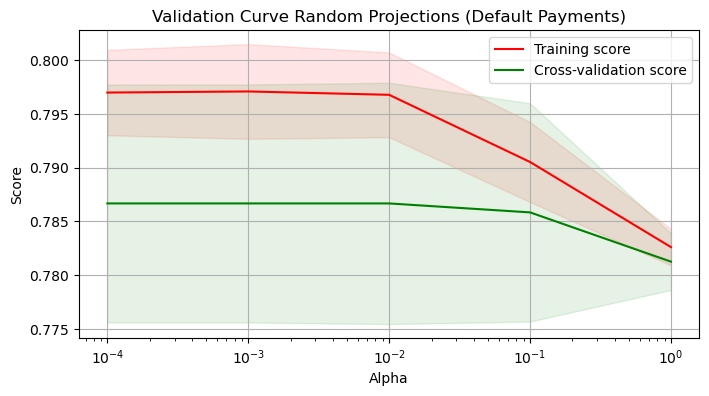

CPU times: user 952 ms, sys: 26.5 ms, total: 978 ms
Wall time: 1.96 s


In [35]:
%%time
# Define the range for the hyperparameter alpha
param_range = [0.0001, 0.001, 0.01, 0.1, 1]

# Function to calculate validation curve with progress bar
def validation_curve_with_progress(estimator, X, y, param_name, param_range, cv, scoring, n_jobs):
    train_scores = []
    test_scores = []
    for param in tqdm(param_range, desc='Validation progress'):
        train_score, test_score = validation_curve(estimator, X, y, param_name=param_name, param_range=[param], cv=cv, scoring=scoring, n_jobs=n_jobs)
        train_scores.append(train_score)
        test_scores.append(test_score)
    return np.array(train_scores).squeeze(), np.array(test_scores).squeeze()

# Calculate validation curve data
train_scores, test_scores = validation_curve_with_progress(
    MLPClassifier(hidden_layer_sizes=(100,), random_state=42), train_X_grp, train_y, param_name="alpha", param_range=param_range, cv=5, scoring="accuracy", n_jobs=-1
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot validation curve
plt.figure(figsize=(8, 4))
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")

plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.title("Validation Curve Random Projections (Default Payments)")
plt.xlabel("Alpha")
plt.ylabel("Score")
plt.xscale('log')  # Use a logarithmic scale for alpha
plt.legend(loc="best")
plt.grid()
plt.savefig('../images/default-payments-nn-rp-validation-curve-alpha.png')
plt.show()

In [36]:
%%time
# Perform 10-fold cross-validation
cv_scores = cross_val_score(neural_net, train_X_grp, train_y, cv=10, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("mean cross-validation score:", cv_scores.mean())

# Write cross-validation scores to a text file
with open('../results/default-payments-nn-rp-cross_validation_scores.txt', 'w') as file:
    file.write("Cross-validation scores: " + np.array2string(cv_scores) + "\n")
    file.write("Mean cross-validation score: " + str(cv_scores.mean()) + "\n")

Cross-validation scores: [0.77083333 0.80833333 0.80416667 0.80833333 0.77916667 0.77916667
 0.76666667 0.76666667 0.8        0.7875    ]
mean cross-validation score: 0.7870833333333332
CPU times: user 1min 30s, sys: 2.03 s, total: 1min 32s
Wall time: 10.5 s


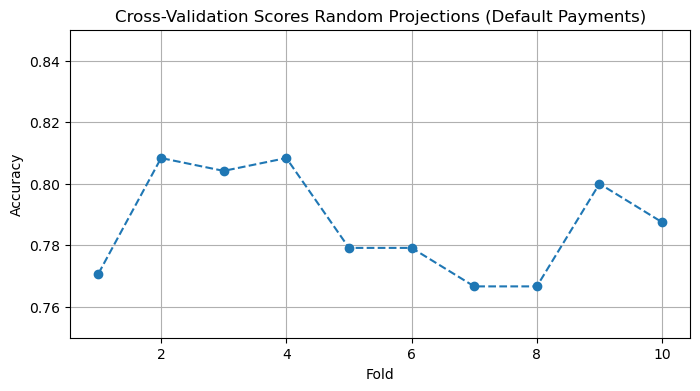

In [37]:
# Plot cross-validation scores
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), cv_scores, marker='o', linestyle='--')
plt.title('Cross-Validation Scores Random Projections (Default Payments)')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim([0.75, .85])
plt.grid(True)
plt.savefig('../images/default-payments-nn-rp-cross-validation-scores.png')
plt.show()

              precision    recall  f1-score   support

           0       0.80      0.97      0.88      1873
           1       0.56      0.13      0.22       527

    accuracy                           0.79      2400
   macro avg       0.68      0.55      0.55      2400
weighted avg       0.75      0.79      0.73      2400



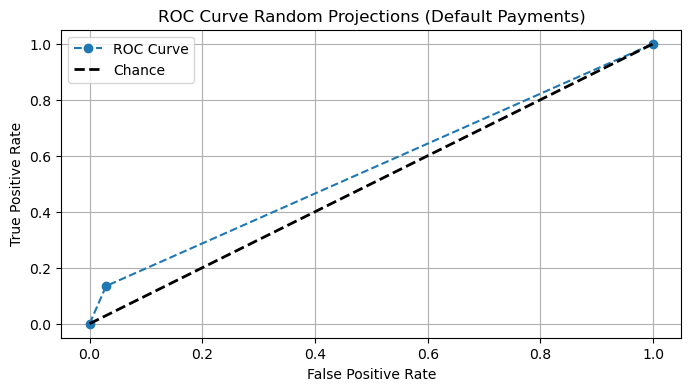

CPU times: user 1min 42s, sys: 4.02 s, total: 1min 46s
Wall time: 12.1 s


In [38]:
%%time
y_pred = cross_val_predict(neural_net, train_X_grp, train_y, cv=10)

report = classification_report(train_y, y_pred)
print(report)

with open('../results/default-payments-nn-rp-classification_report.txt', 'w') as file:
    file.write(report)
    
fpr, tpr, thresholds = roc_curve(train_y, y_pred, pos_label=1)
plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, marker='o', linestyle='--', label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.title('ROC Curve Random Projections (Default Payments)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('../images/default-payments-nn-rp-roc-curve-fpr.png')
plt.show()

/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimize

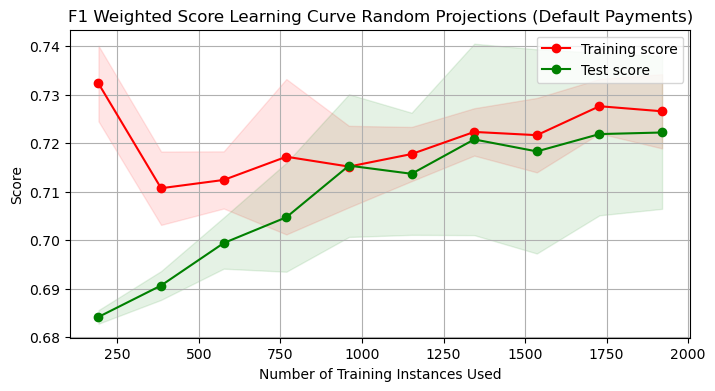

CPU times: user 707 ms, sys: 128 ms, total: 835 ms
Wall time: 940 ms


In [39]:
%%time
best_mlp = MLPClassifier(
    activation='relu',
    alpha=0.0001,
    hidden_layer_sizes=(100,),
    learning_rate='adaptive',
    max_iter=100,
    solver='adam'
)

# Assuming best_mlp, train_X, train_y are already defined
train_sizes, train_scores, test_scores = learning_curve(
    best_mlp, train_X_grp, train_y, cv=5, scoring='f1_weighted',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Calculate mean and standard deviation
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 4))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score")

plt.title('F1 Weighted Score Learning Curve Random Projections (Default Payments)')
plt.xlabel('Number of Training Instances Used')
plt.ylabel('Score')
plt.legend(loc="best")
plt.grid()
plt.savefig('../images/default-payments-nn-rp-best-nn-training-vs-test-set')
plt.show()
# Write to a text file
with open('../results/default-payments-nn-rp-test_classification_results.txt', 'w') as file:
    file.write("Classification Report:\n")
    file.write(test_report + "\n")
    file.write("Confusion Matrix:\n")
    file.write(np.array2string(test_cm) + "\n")

In [40]:
end = time.perf_counter()
print("Time taken: in min", (end - start)/60)

Time taken: in min 3.686411425699771


/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimize